# Stock predication using LSTM 
### The Microsoft(MSFT) stocks was used for the project.
#### Link for data:https://finance.yahoo.com/quote/MSFT/history

#### Select 'Max' in order to have access to the entire data history.The starting date was 1986-03-13 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data= pd.read_csv('MSFT.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060657,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,47894400


In [4]:
# Indexed the Date column
data.index=data.pop('Date')

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060657,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,47894400


### For the sake of this project, we are going to use the 'Close' feature. That is the closing price of the stock for that day

In [6]:
close= data['Close']

In [7]:
close.head()

Date
1986-03-13    0.097222
1986-03-14    0.100694
1986-03-17    0.102431
1986-03-18    0.099826
1986-03-19    0.098090
Name: Close, dtype: float64

<Axes: xlabel='Date'>

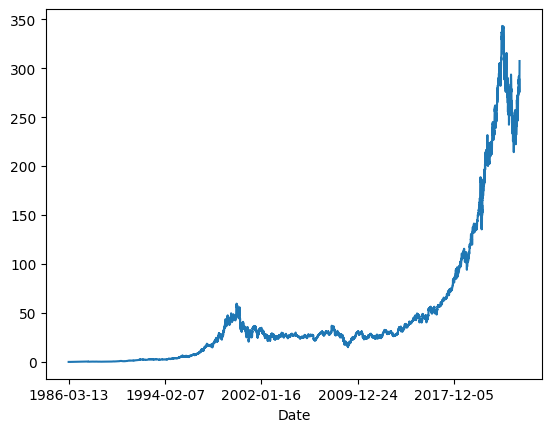

In [8]:
close.plot()

In [9]:
# Going to have to preprocess the dataset

from sklearn.preprocessing import MinMaxScaler

In [10]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
data_scaled = normalizer.fit_transform(np.array(close).reshape(-1,1))


### Splitting the dataset into training and testing data

In [11]:
#Defining test and train data sizes. Used 85% for training
train_size = int(len(data_scaled)*0.85)
test_size = len(data_scaled) - train_size

In [12]:
train_size, test_size

(7954, 1404)

In [13]:
#Splitting data between train and test
data_train, data_test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

## Creating a sliding window

In [14]:
#sliding function

def create_sliding_data(dataset,step):
    xtrain, ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        xtrain.append(a)
        ytrain.append(dataset[i + step, 0])
    return np.array(xtrain), np.array(ytrain)

In [15]:
#We will use the price of 10 days price in order to make the prediction for the 11th day.
# Using the 'create_sliding_data' function
time_stamp = 10
x_train, y_train = create_sliding_data(data_train,time_stamp)
x_test, y_test = create_sliding_data(data_test,time_stamp)

In [16]:
x_train.shape,y_train.shape

((7943, 10), (7943,))

In [17]:
#Reshaping data to fit into LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

# Model Creation

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [19]:
model = Sequential()
model.add(InputLayer((10, 1)))
model.add(LSTM(64,return_sequences=True, activation='relu'))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 50,521
Trainable params: 50,521
Non-trainable params: 0
_________________________________________________________________


In [20]:
# created a model checkpoint and compiled the model
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [21]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[cp])

Epoch 1/100
249/249 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0486

249/249 [==============================] - 23s 53ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2503
Epoch 2/100
248/249 [============================>.] - ETA: 0s - loss: 1.2632e-05 - root_mean_squared_error: 0.0036

249/249 [==============================] - 12s 49ms/step - loss: 1.2632e-05 - root_mean_squared_error: 0.0036 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2067
Epoch 3/100
248/249 [============================>.] - ETA: 0s - loss: 1.1845e-05 - root_mean_squared_error: 0.0034

249/249 [==============================] - 13s 51ms/step - loss: 1.1838e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2016
Epoch 4/100
248/249 [============================>.] - ETA: 0s - loss: 1.1733e-05 - root_mean_squared_error: 0.0034

249/249 [==============================] - 12s 48ms/step - loss: 1.1726e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 5/100
248/249 [============================>.] - ETA: 0s - loss: 1.2064e-05 - root_mean_squared_error: 0.0035

249/249 [==============================] - 12s 50ms/step - loss: 1.2059e-05 - root_mean_squared_error: 0.0035 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1978
Epoch 6/100
248/249 [============================>.] - ETA: 0s - loss: 1.1377e-05 - root_mean_squared_error: 0.0034

249/249 [==============================] - 12s 50ms/step - loss: 1.1368e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1969
Epoch 7/100
249/249 [==============================] - ETA: 0s - loss: 1.1462e-05 - root_mean_squared_error: 0.0034

249/249 [==============================] - 12s 49ms/step - loss: 1.1462e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1964
Epoch 8/100
249/249 [==============================] - 6s 24ms/step - loss: 1.1592e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1968
Epoch 9/100
249/249 [==============================] - 7s 29ms/step - loss: 1.1565e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1981
Epoch 10/100
247/249 [============================>.] - ETA: 0s - loss: 1.1659e-05 - root_mean_squared_error: 0.0034

249/249 [==============================] - 12s 50ms/step - loss: 1.1653e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 11/100
247/249 [============================>.] - ETA: 0s - loss: 1.1849e-05 - root_mean_squared_error: 0.0034

249/249 [==============================] - 12s 50ms/step - loss: 1.1863e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 12/100
249/249 [==============================] - 6s 24ms/step - loss: 1.1346e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1928
Epoch 13/100
249/249 [==============================] - 7s 30ms/step - loss: 1.1310e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1964
Epoch 14/100
248/249 [============================>.] - ETA: 0s - loss: 1.1235e-05 - root_mean_squared_error: 0.0034

249/249 [==============================] - 12s 48ms/step - loss: 1.1229e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 15/100
249/249 [==============================] - 6s 24ms/step - loss: 1.1147e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 16/100
249/249 [==============================] - 7s 29ms/step - loss: 1.1100e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1939
Epoch 17/100
249/249 [==============================] - 6s 24ms/step - loss: 1.1184e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1920
Epoch 18/100
247/249 [============================>.] - ETA: 0s - loss: 1.0844e-05 - root_mean_squared_error: 0.0033

249/249 [==============================] - 13s 52ms/step - loss: 1.0826e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1893
Epoch 19/100
247/249 [============================>.] - ETA: 0s - loss: 1.0741e-05 - root_mean_squared_error: 0.0033

249/249 [==============================] - 13s 52ms/step - loss: 1.0775e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1870
Epoch 20/100
249/249 [==============================] - 7s 30ms/step - loss: 1.0944e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 21/100
249/249 [==============================] - ETA: 0s - loss: 1.0402e-05 - root_mean_squared_error: 0.0032

249/249 [==============================] - 12s 49ms/step - loss: 1.0402e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 22/100
249/249 [==============================] - ETA: 0s - loss: 1.0765e-05 - root_mean_squared_error: 0.0033

249/249 [==============================] - 13s 51ms/step - loss: 1.0765e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1845
Epoch 23/100
249/249 [==============================] - 7s 26ms/step - loss: 1.0738e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1864
Epoch 24/100
249/249 [==============================] - ETA: 0s - loss: 1.0776e-05 - root_mean_squared_error: 0.0033

249/249 [==============================] - 13s 53ms/step - loss: 1.0776e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1803
Epoch 25/100
247/249 [============================>.] - ETA: 0s - loss: 1.0513e-05 - root_mean_squared_error: 0.0032

249/249 [==============================] - 12s 50ms/step - loss: 1.0560e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1793
Epoch 26/100
249/249 [==============================] - 7s 27ms/step - loss: 1.1125e-05 - root_mean_squared_error: 0.0033 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1831
Epoch 27/100
249/249 [==============================] - 7s 27ms/step - loss: 1.0318e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1796
Epoch 28/100
249/249 [==============================] - ETA: 0s - loss: 1.0011e-05 - root_mean_squared_error: 0.0032

249/249 [==============================] - 12s 49ms/step - loss: 1.0011e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1773
Epoch 29/100
247/249 [============================>.] - ETA: 0s - loss: 1.0254e-05 - root_mean_squared_error: 0.0032

249/249 [==============================] - 12s 48ms/step - loss: 1.0286e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1719
Epoch 30/100
249/249 [==============================] - 6s 24ms/step - loss: 1.0014e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1734
Epoch 31/100
249/249 [==============================] - 7s 27ms/step - loss: 9.9786e-06 - root_mean_squared_error: 0.0032 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1771
Epoch 32/100
249/249 [==============================] - 6s 24ms/step - loss: 9.9819e-06 - root_mean_squared_error: 0.0032 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1719
Epoch 33/100
249/249 [==============================] - 7s 27ms/step - loss: 9.9471e-06 - root_mean_squared_error: 0.0032 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1722
Epoch 34/100
249/249 [==============================] - 6s 24ms/step - loss: 9.6847e-06 - root_mean_squared_error: 0.

249/249 [==============================] - 13s 51ms/step - loss: 9.9257e-06 - root_mean_squared_error: 0.0032 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1685
Epoch 36/100
249/249 [==============================] - ETA: 0s - loss: 9.7355e-06 - root_mean_squared_error: 0.0031

249/249 [==============================] - 13s 51ms/step - loss: 9.7355e-06 - root_mean_squared_error: 0.0031 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 37/100
249/249 [==============================] - 6s 25ms/step - loss: 1.0187e-05 - root_mean_squared_error: 0.0032 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 38/100
248/249 [============================>.] - ETA: 0s - loss: 9.6306e-06 - root_mean_squared_error: 0.0031

249/249 [==============================] - 12s 48ms/step - loss: 9.6233e-06 - root_mean_squared_error: 0.0031 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1602
Epoch 39/100
249/249 [==============================] - 7s 27ms/step - loss: 9.5659e-06 - root_mean_squared_error: 0.0031 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1609
Epoch 40/100
248/249 [============================>.] - ETA: 0s - loss: 9.3601e-06 - root_mean_squared_error: 0.0031

249/249 [==============================] - 12s 50ms/step - loss: 9.3563e-06 - root_mean_squared_error: 0.0031 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1569
Epoch 41/100
249/249 [==============================] - 6s 24ms/step - loss: 9.3651e-06 - root_mean_squared_error: 0.0031 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1588
Epoch 42/100
248/249 [============================>.] - ETA: 0s - loss: 9.3107e-06 - root_mean_squared_error: 0.0031

249/249 [==============================] - 13s 51ms/step - loss: 9.3033e-06 - root_mean_squared_error: 0.0031 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 43/100
248/249 [============================>.] - ETA: 0s - loss: 9.1681e-06 - root_mean_squared_error: 0.0030

249/249 [==============================] - 12s 49ms/step - loss: 9.1698e-06 - root_mean_squared_error: 0.0030 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1520
Epoch 44/100
248/249 [============================>.] - ETA: 0s - loss: 9.2529e-06 - root_mean_squared_error: 0.0030

249/249 [==============================] - 13s 53ms/step - loss: 9.2593e-06 - root_mean_squared_error: 0.0030 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1496
Epoch 45/100
249/249 [==============================] - 6s 26ms/step - loss: 8.7863e-06 - root_mean_squared_error: 0.0030 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1498
Epoch 46/100
248/249 [============================>.] - ETA: 0s - loss: 8.9095e-06 - root_mean_squared_error: 0.0030

249/249 [==============================] - 12s 49ms/step - loss: 8.9038e-06 - root_mean_squared_error: 0.0030 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1452
Epoch 47/100
247/249 [============================>.] - ETA: 0s - loss: 8.5086e-06 - root_mean_squared_error: 0.0029

249/249 [==============================] - 13s 51ms/step - loss: 8.5475e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 48/100
249/249 [==============================] - 7s 28ms/step - loss: 8.7794e-06 - root_mean_squared_error: 0.0030 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1446
Epoch 49/100
249/249 [==============================] - ETA: 0s - loss: 8.6898e-06 - root_mean_squared_error: 0.0029

249/249 [==============================] - 12s 49ms/step - loss: 8.6898e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1389
Epoch 50/100
249/249 [==============================] - 6s 24ms/step - loss: 8.5667e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1437
Epoch 51/100
248/249 [============================>.] - ETA: 0s - loss: 8.4009e-06 - root_mean_squared_error: 0.0029

249/249 [==============================] - 12s 49ms/step - loss: 8.3944e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1336
Epoch 52/100
247/249 [============================>.] - ETA: 0s - loss: 8.1486e-06 - root_mean_squared_error: 0.0029

249/249 [==============================] - 13s 51ms/step - loss: 8.2419e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 53/100
248/249 [============================>.] - ETA: 0s - loss: 8.2471e-06 - root_mean_squared_error: 0.0029

249/249 [==============================] - 13s 51ms/step - loss: 8.2467e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1323
Epoch 54/100
249/249 [==============================] - ETA: 0s - loss: 8.6521e-06 - root_mean_squared_error: 0.0029

249/249 [==============================] - 12s 49ms/step - loss: 8.6521e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1259
Epoch 55/100
249/249 [==============================] - 6s 25ms/step - loss: 8.1928e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1269
Epoch 56/100
249/249 [==============================] - 7s 28ms/step - loss: 8.0838e-06 - root_mean_squared_error: 0.0028 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1271
Epoch 57/100
248/249 [============================>.] - ETA: 0s - loss: 7.9947e-06 - root_mean_squared_error: 0.0028

249/249 [==============================] - 12s 49ms/step - loss: 7.9888e-06 - root_mean_squared_error: 0.0028 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 58/100
249/249 [==============================] - ETA: 0s - loss: 7.9138e-06 - root_mean_squared_error: 0.0028

249/249 [==============================] - 12s 47ms/step - loss: 7.9138e-06 - root_mean_squared_error: 0.0028 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 59/100
248/249 [============================>.] - ETA: 0s - loss: 7.8663e-06 - root_mean_squared_error: 0.0028

249/249 [==============================] - 12s 49ms/step - loss: 7.8632e-06 - root_mean_squared_error: 0.0028 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1165
Epoch 60/100
249/249 [==============================] - 6s 24ms/step - loss: 8.4105e-06 - root_mean_squared_error: 0.0029 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 61/100
249/249 [==============================] - ETA: 0s - loss: 7.5613e-06 - root_mean_squared_error: 0.0027

249/249 [==============================] - 13s 51ms/step - loss: 7.5613e-06 - root_mean_squared_error: 0.0027 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 62/100
249/249 [==============================] - ETA: 0s - loss: 7.6556e-06 - root_mean_squared_error: 0.0028

249/249 [==============================] - 12s 49ms/step - loss: 7.6556e-06 - root_mean_squared_error: 0.0028 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 63/100
248/249 [============================>.] - ETA: 0s - loss: 7.6070e-06 - root_mean_squared_error: 0.0028

249/249 [==============================] - 13s 51ms/step - loss: 7.6060e-06 - root_mean_squared_error: 0.0028 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 64/100
249/249 [==============================] - ETA: 0s - loss: 7.3777e-06 - root_mean_squared_error: 0.0027

249/249 [==============================] - 12s 49ms/step - loss: 7.3777e-06 - root_mean_squared_error: 0.0027 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 65/100
249/249 [==============================] - 6s 26ms/step - loss: 7.3379e-06 - root_mean_squared_error: 0.0027 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 66/100
248/249 [============================>.] - ETA: 0s - loss: 7.2601e-06 - root_mean_squared_error: 0.0027

249/249 [==============================] - 13s 51ms/step - loss: 7.2557e-06 - root_mean_squared_error: 0.0027 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 67/100
249/249 [==============================] - 7s 28ms/step - loss: 7.3344e-06 - root_mean_squared_error: 0.0027 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 68/100
247/249 [============================>.] - ETA: 0s - loss: 7.2489e-06 - root_mean_squared_error: 0.0027

249/249 [==============================] - 12s 49ms/step - loss: 7.2234e-06 - root_mean_squared_error: 0.0027 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0967
Epoch 69/100
248/249 [============================>.] - ETA: 0s - loss: 7.6040e-06 - root_mean_squared_error: 0.0028

249/249 [==============================] - 12s 47ms/step - loss: 7.6029e-06 - root_mean_squared_error: 0.0028 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 70/100
247/249 [============================>.] - ETA: 0s - loss: 6.9348e-06 - root_mean_squared_error: 0.0026

249/249 [==============================] - 12s 50ms/step - loss: 6.9158e-06 - root_mean_squared_error: 0.0026 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930
Epoch 71/100
247/249 [============================>.] - ETA: 0s - loss: 6.7659e-06 - root_mean_squared_error: 0.0026

249/249 [==============================] - 12s 49ms/step - loss: 6.7565e-06 - root_mean_squared_error: 0.0026 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 72/100
248/249 [============================>.] - ETA: 0s - loss: 6.5616e-06 - root_mean_squared_error: 0.0026

249/249 [==============================] - 12s 47ms/step - loss: 6.5689e-06 - root_mean_squared_error: 0.0026 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838
Epoch 73/100
248/249 [============================>.] - ETA: 0s - loss: 7.0277e-06 - root_mean_squared_error: 0.0027

249/249 [==============================] - 12s 49ms/step - loss: 7.0246e-06 - root_mean_squared_error: 0.0027 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834
Epoch 74/100
248/249 [============================>.] - ETA: 0s - loss: 6.8280e-06 - root_mean_squared_error: 0.0026

249/249 [==============================] - 12s 48ms/step - loss: 6.8259e-06 - root_mean_squared_error: 0.0026 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0833
Epoch 75/100
249/249 [==============================] - ETA: 0s - loss: 6.7649e-06 - root_mean_squared_error: 0.0026

249/249 [==============================] - 12s 48ms/step - loss: 6.7649e-06 - root_mean_squared_error: 0.0026 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 76/100
248/249 [============================>.] - ETA: 0s - loss: 6.6125e-06 - root_mean_squared_error: 0.0026

249/249 [==============================] - 12s 50ms/step - loss: 6.6076e-06 - root_mean_squared_error: 0.0026 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 77/100
249/249 [==============================] - ETA: 0s - loss: 6.3473e-06 - root_mean_squared_error: 0.0025

249/249 [==============================] - 13s 50ms/step - loss: 6.3473e-06 - root_mean_squared_error: 0.0025 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 78/100
247/249 [============================>.] - ETA: 0s - loss: 6.6124e-06 - root_mean_squared_error: 0.0026

249/249 [==============================] - 12s 49ms/step - loss: 6.6017e-06 - root_mean_squared_error: 0.0026 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 79/100
249/249 [==============================] - ETA: 0s - loss: 6.1005e-06 - root_mean_squared_error: 0.0025

249/249 [==============================] - 13s 51ms/step - loss: 6.1005e-06 - root_mean_squared_error: 0.0025 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 80/100
249/249 [==============================] - ETA: 0s - loss: 6.1374e-06 - root_mean_squared_error: 0.0025

249/249 [==============================] - 13s 50ms/step - loss: 6.1374e-06 - root_mean_squared_error: 0.0025 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 81/100
248/249 [============================>.] - ETA: 0s - loss: 6.1951e-06 - root_mean_squared_error: 0.0025

249/249 [==============================] - 12s 49ms/step - loss: 6.1913e-06 - root_mean_squared_error: 0.0025 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 82/100
249/249 [==============================] - ETA: 0s - loss: 6.3045e-06 - root_mean_squared_error: 0.0025

249/249 [==============================] - 13s 51ms/step - loss: 6.3045e-06 - root_mean_squared_error: 0.0025 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 83/100
249/249 [==============================] - 7s 27ms/step - loss: 6.1487e-06 - root_mean_squared_error: 0.0025 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
Epoch 84/100
248/249 [============================>.] - ETA: 0s - loss: 6.1038e-06 - root_mean_squared_error: 0.0025

249/249 [==============================] - 12s 47ms/step - loss: 6.1034e-06 - root_mean_squared_error: 0.0025 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 85/100
249/249 [==============================] - ETA: 0s - loss: 5.8809e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 49ms/step - loss: 5.8809e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 86/100
248/249 [============================>.] - ETA: 0s - loss: 5.8804e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 49ms/step - loss: 5.9125e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 87/100
249/249 [==============================] - ETA: 0s - loss: 5.8493e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 48ms/step - loss: 5.8493e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 88/100
247/249 [============================>.] - ETA: 0s - loss: 5.8279e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 50ms/step - loss: 5.8237e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 89/100
247/249 [============================>.] - ETA: 0s - loss: 5.6856e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 50ms/step - loss: 5.6807e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 90/100
248/249 [============================>.] - ETA: 0s - loss: 5.9068e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 49ms/step - loss: 5.9040e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 91/100
248/249 [============================>.] - ETA: 0s - loss: 5.8359e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 13s 51ms/step - loss: 5.8355e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 92/100
248/249 [============================>.] - ETA: 0s - loss: 5.8896e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 50ms/step - loss: 5.9066e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 93/100
247/249 [============================>.] - ETA: 0s - loss: 5.7498e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 49ms/step - loss: 5.7520e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 94/100
249/249 [==============================] - 7s 27ms/step - loss: 5.5164e-06 - root_mean_squared_error: 0.0023 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 95/100
249/249 [==============================] - ETA: 0s - loss: 5.7540e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 13s 51ms/step - loss: 5.7540e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 96/100
249/249 [==============================] - ETA: 0s - loss: 5.6313e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 13s 51ms/step - loss: 5.6313e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 97/100
249/249 [==============================] - ETA: 0s - loss: 5.6094e-06 - root_mean_squared_error: 0.0024

249/249 [==============================] - 12s 48ms/step - loss: 5.6094e-06 - root_mean_squared_error: 0.0024 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 98/100
249/249 [==============================] - ETA: 0s - loss: 5.3449e-06 - root_mean_squared_error: 0.0023

249/249 [==============================] - 13s 52ms/step - loss: 5.3449e-06 - root_mean_squared_error: 0.0023 - val_loss: 9.8619e-04 - val_root_mean_squared_error: 0.0314
Epoch 99/100
248/249 [============================>.] - ETA: 0s - loss: 5.4534e-06 - root_mean_squared_error: 0.0023

249/249 [==============================] - 13s 51ms/step - loss: 5.4529e-06 - root_mean_squared_error: 0.0023 - val_loss: 9.7069e-04 - val_root_mean_squared_error: 0.0312
Epoch 100/100
249/249 [==============================] - 7s 28ms/step - loss: 5.4869e-06 - root_mean_squared_error: 0.0023 - val_loss: 9.7563e-04 - val_root_mean_squared_error: 0.0312


In [22]:
from tensorflow.keras.models import load_model
model = load_model('model/')


In [23]:
test_predictions = model.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actual_value':y_test})
test_results

44/44 [==============================] - 1s 4ms/step


,Test Predictions,Actual_value
0,0.223489,0.225642
1,0.224493,0.226109
2,0.225414,0.225934
3,0.225995,0.225992
4,0.226363,0.226867
...,...,...
1388,0.799040,0.832809
1389,0.797974,0.821176
1390,0.796713,0.802664
1391,0.795639,0.860824


In [24]:
# this is a combination of both train and test data predicted by the model
train_prediction=model.predict(x_train)
test_prediction=model.predict(x_test)

44/44 [==============================] - 0s 4ms/step


In [25]:
#Inverse transform to get actual values
train_predict = normalizer.inverse_transform(train_prediction)
test_predict = normalizer.inverse_transform(test_prediction)

In [26]:
test_predict

array([[ 76.75144 ],
       [ 77.095924],
       [ 77.41164 ],
       ...,
       [273.37866 ],
       [273.0102  ],
       [273.24167 ]], dtype=float32)

In [27]:
# combining both train and test predictions of the model
testdata = np.vstack((train_predict,test_predict))

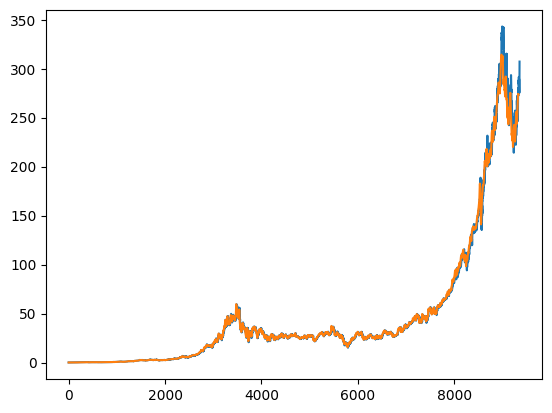

In [28]:
#comparing the original dataset and the generated data by the model
plt.plot(normalizer.inverse_transform(data_scaled))
plt.plot(testdata)

# Make predictions for the next 30 days

In [29]:
len(data_test)

1404

In [30]:
#find the last 10 days records
last_val = data_test[1304:]
last_val=last_val.reshape(1,-1)

In [31]:
last_val.shape

(1, 100)

In [32]:
# converting last_val to a list
list_last_val=list(last_val)

In [33]:
list_last_val = list_last_val[0].tolist()

In [34]:
#Predicting next 30 days price using the current data
#It will predict in a sliding window manner 
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(list_last_val)>100):
        last_val = np.array(list_last_val[1:])
        last_val=last_val.reshape(1,-1)
        last_val = last_val.reshape((1, n_steps, 1))
        yhat = model.predict(last_val, verbose=0)
        list_last_val.extend(yhat[0].tolist())
        list_last_val = list_last_val[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        last_val = last_val.reshape((1, n_steps,1))
        yhat = model.predict(last_val, verbose=0)
        list_last_val.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.897819459438324], [0.9215214252471924], [0.9515624642372131], [0.9898741245269775], [1.0326462984085083], [1.051856517791748], [1.0735752582550049], [1.0971674919128418], [1.1222236156463623], [1.1484856605529785], [1.1757928133010864], [1.204012155532837], [1.2330262660980225], [1.2627177238464355], [1.2866464853286743], [1.3034237623214722], [1.3197990655899048], [1.335599660873413], [1.3507753610610962], [1.3653459548950195], [1.3793730735778809], [1.3929330110549927], [1.406097650527954], [1.4189242124557495], [1.4314501285552979], [1.4436975717544556], [1.4556854963302612], [1.4674458503723145], [1.4789724349975586], [1.4902456998825073]]


### Plotting the dataset alongside the new predictions 

In [35]:
#Inverse transform to get actual values
new_prediction = normalizer.inverse_transform(lst_output)


In [36]:
new_prediction

array([[308.06004592],
       [316.19028728],
       [326.49495567],
       [339.63661016],
       [354.30830871],
       [360.89779254],
       [368.34774853],
       [376.44034961],
       [385.03509383],
       [394.04349278],
       [403.41038431],
       [413.09017482],
       [423.04258652],
       [433.22734166],
       [441.43537841],
       [447.19031505],
       [452.80736678],
       [458.22728234],
       [463.43284657],
       [468.4308474 ],
       [473.24242554],
       [477.89375132],
       [482.4094821 ],
       [486.80924561],
       [491.10588168],
       [495.30699606],
       [499.41909044],
       [503.45312363],
       [507.40696931],
       [511.27392133]])

In [37]:
#Creating a dummy plane to plot graph one after another
nu=(len(testdata))
plot_new=np.arange(0,nu)
plot_pred=np.arange((nu+1),(nu+31))

In [38]:
print(len(testdata))

9336


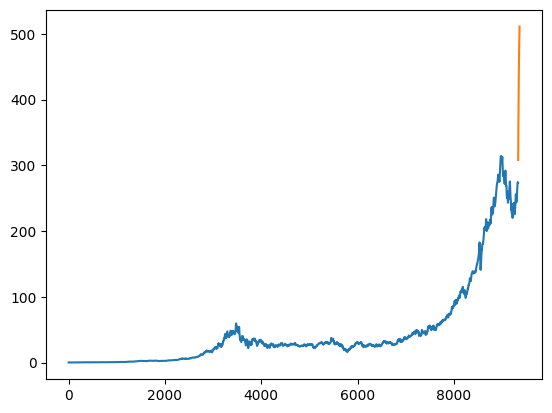

In [39]:
plt.plot(plot_new, testdata)
plt.plot(plot_pred, new_prediction)

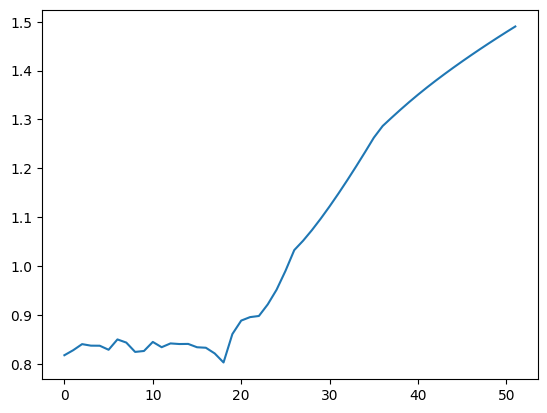

In [40]:
# Combining the predicted values into the graph
#Entends helps us to fill the missing value with approx value
new_data = data_scaled.tolist()
new_data.extend(lst_output)
plt.plot(new_data[nu:])

In [41]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(new_data).tolist()


Text(0.5, 0, 'Time')

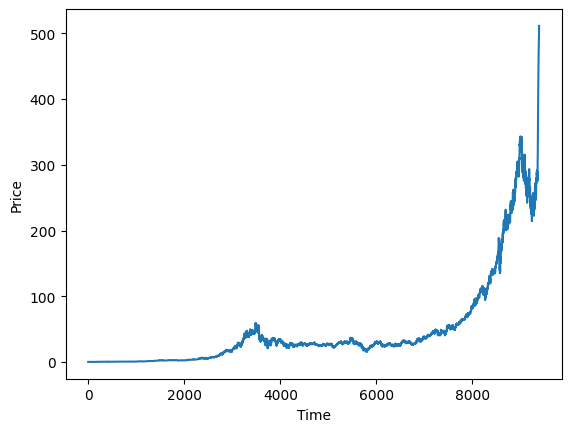

In [42]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")


### From the above graph we can notice a hike in the stock price